# Proyek Klasifikasi Gambar: Chest X-Ray Images
- **Nama:** mellania permata
- **Email:** xxx
- **ID Dicoding:** mellaniapermata

## Import Semua Packages/Library yang Digunakan

In [18]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import seaborn as sns
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

Unduh data dari Kaggle

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mellaniasylvie","key":"551717b37c442f5542b300cc06d0a2d0"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [00:42<00:00, 29.9MB/s]
100% 1.17G/1.17G [00:42<00:00, 29.3MB/s]


Ekstrak ZIP File

In [7]:
!unzip labeled-chest-xray-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-26

Menentukan direktori dataset

In [8]:
# Direktori awal untuk train dan test
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

# Direktori baru untuk dataset gabungan
combined_dir = "chest_xray/dataset"

In [9]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [10]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

Dataset Checking

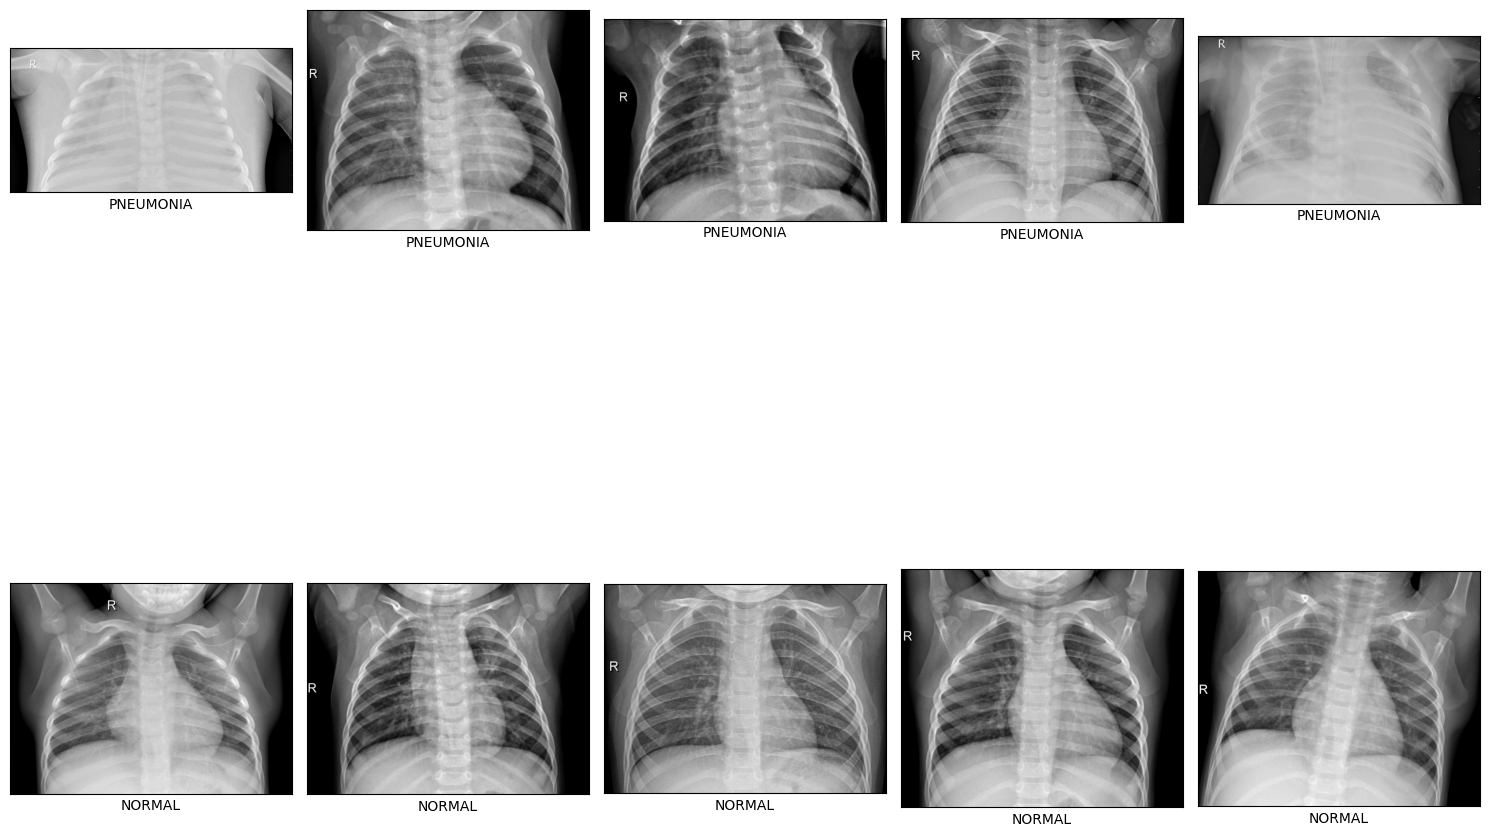

In [14]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "chest_xray/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

Plot Distribusi Data

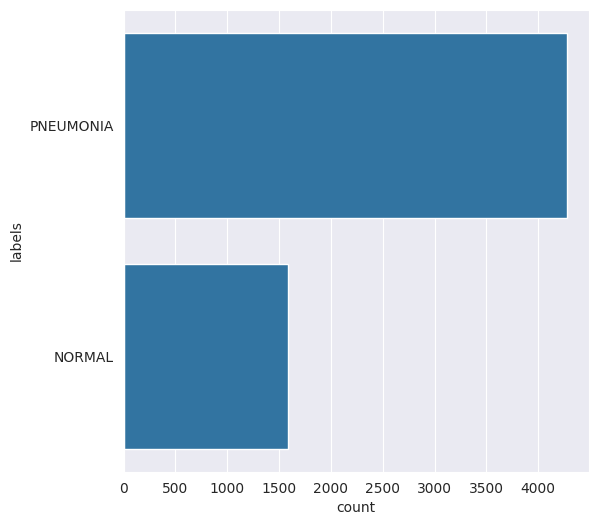

In [17]:
# Definisikan path sumber
lung_path = "chest_xray/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [26]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
NORMAL,1583
PNEUMONIA,4273


In [27]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [28]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [29]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        289
       PNEUMONIA     883
train  NORMAL       1294
       PNEUMONIA    3390
dtype: int64 


                                                   path     labels    set
1912  chest_xray/dataset/PNEUMONIA/BACTERIA-9511251-...  PNEUMONIA  train
823   chest_xray/dataset/PNEUMONIA/VIRUS-6831597-000...  PNEUMONIA  train
1473  chest_xray/dataset/PNEUMONIA/VIRUS-7343289-000...  PNEUMONIA  train
2031  chest_xray/dataset/PNEUMONIA/BACTERIA-4213815-...  PNEUMONIA  train
1660  chest_xray/dataset/NORMAL/NORMAL-6943766-0002....     NORMAL  train


In [30]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Augmentasi ImageData Generator

In [31]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')

print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  1294
Total number of pneumonic images in training set:  3390
Total number of normal images in test set:  289
Total number of pneumonic images in test set:  883


In [32]:
# Buat objek ImageDataGenerator yang menormalkan gambar
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split = 0.2)

val_datagen = ImageDataGenerator(rescale=1/255.,
                                 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


## Modelling

In [35]:
from keras import regularizers
from keras.regularizers import L2

model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 73, 73, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,183,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,202,817 (4.59 MB)

 Trainable params: 1,202,817 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Model

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [38]:
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [39]:
%%time
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr],
                    shuffle = True)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 320ms/step - accuracy: 0.7083 - loss: 0.7922 - val_accuracy: 0.8814 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 278ms/step - accuracy: 0.8065 - loss: 0.4804 - val_accuracy: 0.8910 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 279ms/step - accuracy: 0.8182 - loss: 0.4391 - val_accuracy: 0.9423 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - accuracy: 0.8399 - loss: 0.4020 - val_accuracy: 0.9466 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 272ms/step - accuracy: 0.8588 - loss: 0.4055 - val_accuracy: 0.9167 - val_loss: 0.2932 - learning_rate: 0.0010
CPU times: user 2min 54s, sys: 3.03 s, total: 2min 57s
Wall time: 3min 2s


## Evaluasi dan Visualisasi

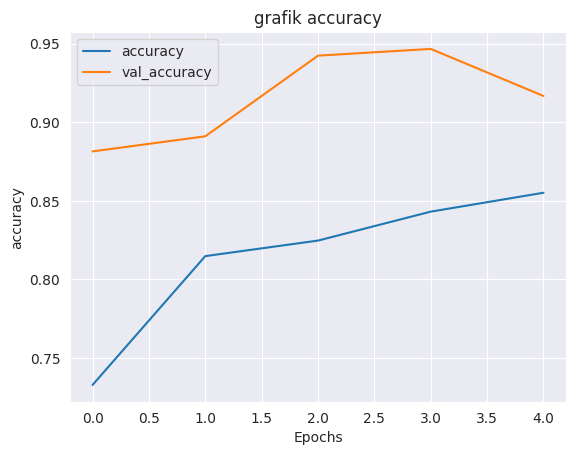

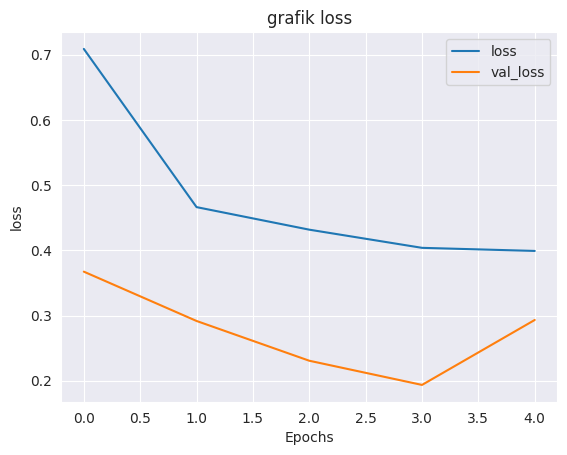

In [40]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

grafik_plot(history, "accuracy")
grafik_plot(history, "loss")



              precision    recall  f1-score   support

      Normal     0.8677    0.7716    0.8168       289
   Pneumonia     0.9279    0.9615    0.9444       883

    accuracy                         0.9147      1172
   macro avg     0.8978    0.8666    0.8806      1172
weighted avg     0.9130    0.9147    0.9129      1172



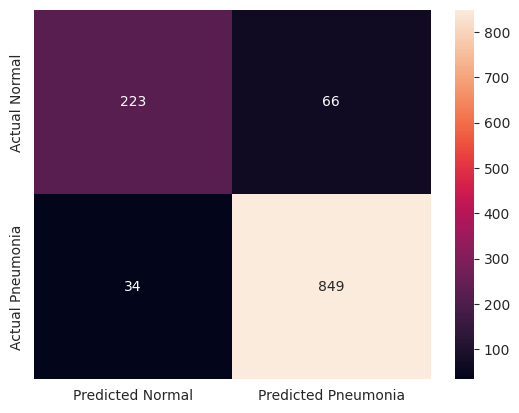

In [43]:
test_generator.reset()

preds_1 = model.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))

## Konversi Model

In [44]:
model.save('pneumonia.h5')

Konversi ke format saved model

In [45]:
save_path = '/content/mymodel/'
tf.saved_model.save(model, save_path)

Konversi TFLite

In [46]:
# Load model Keras
model = tf.keras.models.load_model("pneumonia.h5")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open("pneumonia_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpo1nsgxnj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132458484823632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132458484814992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132458484825744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132458484819216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132458484819024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456631176272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456631176464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456631174736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456631174928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456631173392: TensorSpec(shape=(), dtype=tf.resource, name=None)


Konversi TFJS

In [47]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successful

In [48]:
!tensorflowjs_converter --input_format=keras pneumonia.h5 tfjs_model

2025-05-19 01:55:08.552683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747619708.588446   15675 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747619708.599036   15675 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747619708.647039   15675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747619708.647077   15675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747619708.647086   15675 computation_placer.cc:177] computation placer alr

In [49]:
shutil.make_archive('mymodel', 'zip', 'mymodel')

'/content/mymodel.zip'

In [51]:
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

'/content/tfjs_model.zip'

## Inference (Optional)

Saving BACTERIA-1041881-0002.jpeg to BACTERIA-1041881-0002 (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
BACTERIA-1041881-0002 (2).jpeg
[[1.]]
Pneumonia


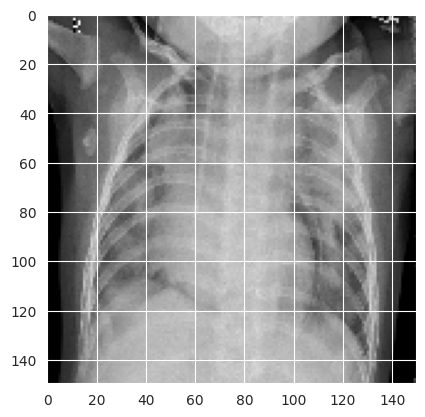

In [56]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded_files = files.upload()

for pic in uploaded_files.keys():
  path = pic
  # Load the image in grayscale to match the model's expected input shape
  img = image.load_img(path, target_size=(150,150), color_mode="grayscale")
  imgplot = plt.imshow(img, cmap='gray') # Display in grayscale
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  print(pic)
  print(classes)
  if classes==0:
   print('Normal')
  elif classes==1:
   print('Pneumonia')

Berkas requirements.txt

In [57]:
!pip freeze > requirements.txt